# Sentiment Analysis of Customer Reviews at ShopSmart


Imagine you're working as a data analyst at ShopSmart, a large e-commerce company. The company collects thousands of product reviews every day. Your task is to build a sentiment analysis pipeline to automatically classify reviews as positive or negative, allowing the customer service team to prioritize issues and highlight top-rated products.

In [ ]:
# SECTION 1: Simulate and Explore Customer Reviews (Messier Version)
import pandas as pd
import numpy as np
import random

# Sample reviews (with natural variation)
positive_reviews = [
    "This product is excellent, I love it!",
    "Very satisfied with the quality and service.",
    "Exceeded my expectations, totally worth the price.",
    "Great customer support and fast delivery.",
    "Amazing build quality. Highly recommend."
]

negative_reviews = [
    "This is terrible. It broke after one use.",
    "Very disappointed. Not worth the money.",
    "Customer service was unhelpful and rude.",
    "Shipping was delayed and product was damaged.",
    "Worst purchase I've ever made."
]

neutral_reviews = [
    "It’s okay, nothing special.",
    "Average quality for the price.",
    "The product is fine, but delivery took too long."
]

data = []
for _ in range(120):
    # Bias toward positive
    if random.random() < 0.6:
        text = random.choice(positive_reviews)
        sentiment = 1
    elif random.random() < 0.5:
        text = random.choice(negative_reviews)
        sentiment = 0
    else:
        text = random.choice(neutral_reviews)
        sentiment = random.choice([0, 1])  # ambiguous labeling

    # Add noise: typos, casing, extra spaces
    if random.random() < 0.15:
        text = text.lower()
    if random.random() < 0.1:
        text = text.replace(" ", "  ")
    if random.random() < 0.05:
        text = text.replace("o", "0")

    # Occasionally mislabel sentiment
    if random.random() < 0.05:
        sentiment = 1 - sentiment

    # Occasionally insert missing value
    if random.random() < 0.03:
        text = None

    data.append((text, sentiment))

df = pd.DataFrame(data, columns=["Review", "Sentiment"])

print(df["Sentiment"].value_counts())
df.head(10)


Sentiment
1    85
0    35
Name: count, dtype: int64


,Review,Sentiment
0,Great customer support and fast delivery.,1
1,Great customer support and fast delivery.,1
2,This is terrible. It broke after one use.,0
3,"This product is excellent, I love it!",1
4,Very satisfied with the quality and service.,1
5,Customer service was unhelpful and rude.,0
6,Very satisfied with the quality and service.,1
7,Shipping was delayed and product was damaged.,0
8,Shipping was delayed and product was damaged.,0
9,Shipping was delayed and product was dam...,0


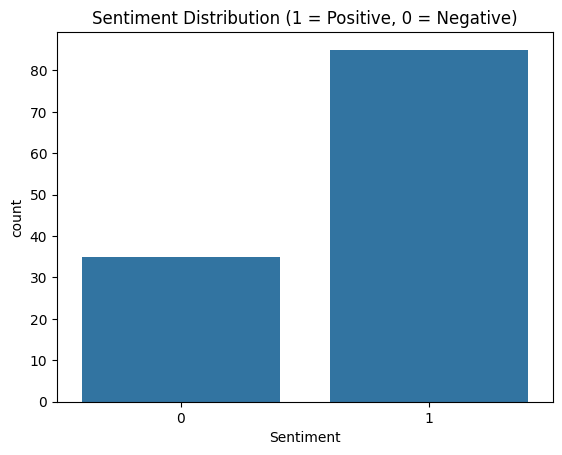

In [ ]:
# Basic EDA
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="Sentiment")
plt.title("Sentiment Distribution (1 = Positive, 0 = Negative)")
plt.show()


# NLP Pipeline for Sentiment Classification

The NLP Pipeline for Sentiment Classification transforms unstructured customer reviews into structured data that can be used to predict sentiment. It begins by cleaning the text, which includes lowercasing and removing punctuation or special characters to ensure consistency. After preprocessing, the pipeline uses TF-IDF vectorization to convert the cleaned text into numerical features by capturing how important each word is across all reviews. These features are then passed into a logistic regression model, a simple yet effective classification algorithm, to learn the patterns associated with positive and negative sentiment. Once trained, the model can automatically classify new reviews, allowing businesses to quickly identify customer satisfaction trends and flag issues for follow-up. This pipeline demonstrates a foundational NLP approach commonly used in customer feedback analysis, social media monitoring, and product review classification.

In [ ]:
# SECTION 2: NLP Pipeline (works with simulated "df")
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1) Clean text safely
def clean_text(text):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return ""
    text = str(text).lower()
    text = re.sub(r"\s+", " ", text)        # collapse extra spaces
    text = re.sub(r"[^a-z\s]", " ", text)   # keep letters and spaces
    return text.strip()

# 2) Prepare data: drop rows with missing/empty reviews or labels
work = df.dropna(subset=["Review", "Sentiment"]).copy()
work["Cleaned_Review"] = work["Review"].apply(clean_text)
work = work[work["Cleaned_Review"].str.len() > 0].copy()  # remove empty after cleaning

# Ensure labels are ints 0/1
work["Sentiment"] = work["Sentiment"].astype(int)

# 3) Split
X_train, X_test, y_train, y_test = train_test_split(
    work["Cleaned_Review"], work["Sentiment"],
    test_size=0.2, random_state=42, stratify=work["Sentiment"]
)

# 4) Vectorize
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),   # unigrams + bigrams handle short reviews better
    min_df=2              # ignore singletons to reduce noise from typos
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 5) Train classifier
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # safer with your slight skew
    n_jobs=None               # keep default for portability
)
model.fit(X_train_vec, y_train)

# 6) Evaluate
y_pred = model.predict(X_test_vec)
print("Class balance in y_test:\n", pd.Series(y_test).value_counts(normalize=True).round(3))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


Class balance in y_test:
 Sentiment
1    0.708
0    0.292
Name: proportion, dtype: float64

Classification report:

              precision    recall  f1-score   support

    Negative       0.71      0.71      0.71         7
    Positive       0.88      0.88      0.88        17

    accuracy                           0.83        24
   macro avg       0.80      0.80      0.80        24
weighted avg       0.83      0.83      0.83        24



## Review Questions

1. **How is the text data for this notebook created?**

   A. Loaded from a real customer review dataset  
   B. Scraped from an external website  
   C. Simulated using predefined positive and negative review strings  
   D. Entered manually by the user  

2. **What does the `label` column represent in the review dataset?**

   A. The product ID  
   B. The length of the review  
   C. Whether the review sentiment is positive or negative  
   D. The confidence score of the model  

3. **Which preprocessing step converts the raw review text into numeric features?**

   A. StandardScaler  
   B. One-hot encoding  
   C. TF-IDF vectorization  
   D. Principal component analysis  

4. **Which model is fit to the vectorized review data?**

   A. Linear regression  
   B. Logistic regression  
   C. Random forest  
   D. Support vector regression  

5. **What output is used to evaluate the model’s performance in the notebook?**

   A. Mean squared error  
   B. Feature importance plot  
   C. Classification report with precision and recall  
   D. Confusion matrix only  

